In [1]:
import numpy as np
import sys
import pandas as pd
# sys.path.append('../')
import matplotlib.pyplot as plt
from scipy import signal

import matplotlib.patches
import seaborn as sns
from matplotlib.colors import LogNorm

# from ALT_F_BIND_chromo_vertex_nuclear_competitive_2_density import eval_f_bind_competitive_2, eval_f_bind_competitive_arr_2
from ALT_F_BIND_chromo_vertex_nuclear_competitive_2_density import *

implementing a binding model that considers looping behavior (or just self-interaction due to configuration) of chromosome, as opposed to old binding model which does not consider the impact of looping on the interaction (mean field only). Notes on theory in gmail, title "9/18 meeting binding model with looping"

# Binding states with no looping (old theory)

In [471]:
np.arange(-5,-1,1)

array([-5, -4, -3, -2])

In [473]:
%%time

mu_max = -1#-2.9#-4.6#0.1 #10
mu_min = -5#-4.8#-9
del_mu = 1#.1 #0.25

e_m = [1.52, 1.52]
v_int = np.array([[-4,0],[0,-4]])

mu1_array = np.arange(mu_min, mu_max, del_mu)#[-5]
mu2_array = np.arange(mu_min, mu_max, del_mu)#[-5]

n_bind = 2 #types of proteins/marks

rho_c = (3e7)  /  ((4/3) * np.pi*  (5)**3 * (1000/1)**3) # nucleosomes per nm^3

avo = 6.02e23
water_molmas = 18
rho_s = avo * (1/water_molmas) * (1000  *(1000/1) * (1/1e9)**3)#  num / nm^3

chrom_type = "DNA"
marks_1 = np.loadtxt(r"HNCFF683HCZ_H3K9me3_methyl.txt").astype(np.uint8)
marks_2 = np.loadtxt(r"ENCFF919DOR_H3K27me3_methyl.txt").astype(np.uint8)

poly_marks = [marks_1, marks_2]

chrom = def_chrom(n_bind, v_int, e_m, rho_c, rho_s, poly_marks, mu_max, mu_min, del_mu, chrom_type)

[n_bind, v_int, Vol_int, e_m, rho_c, rho_s, poly_marks, M, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom

f_gam_noloop, s_bind_soln_arr_noloop = calc_binding_states(chrom)

# sig_to_frac_dic={}
sig_to_int_dic={}
i=0
for om1 in range(3):
    for om2 in range(3):
        key = repr([om1,om2])
        # frac = np.sum((marks_1 == om1)*1 * (marks_2 == om2)*1)/len(marks_1) #fraction of nucleosomes with sigma = [sig_1, sig_2]

        # sig_to_frac_dic[key] = frac
        sig_to_int_dic[key] = i
        i+=1

pairs = np.column_stack(poly_marks)
pairs_ind = np.zeros(len(marks_1), dtype = int) # for each nucleosome (2 mark values), the corresponding index in s_bnd

for i,sig_pair in enumerate(pairs):
    key = repr(list(sig_pair))
    ind = sig_to_int_dic[key]
#     print(type(ind))
    pairs_ind[i] = ind 

# print("saved settings file")

CPU times: total: 2.86 s
Wall time: 9.52 s


# Self-consistent binding state solution with looping/self-interaction

In [475]:
def calc_s_bind_comp(ws, mus, f_binds):
    f_bind_10, f_bind_01, f_bind_20, f_bind_02, f_bind_11 = f_binds
    mu_1, mu_2 = mus
    # sigma1, sigma2 = sigmas
    w_1, w_2 = ws

    # boltzmann probability of each binding state [s_HP1, s_PRC1]
    p_00 = 1
    p_10 = np.exp(-f_bind_10 + mu_1*1 - w_1*1) 
    p_01 = np.exp(-f_bind_01 + mu_2*1 - w_2*1)
    p_20 = np.exp(-f_bind_20 + mu_1*2 - w_1*2)
    p_02 = np.exp(-f_bind_02 + mu_2*2 - w_2*2)
    p_11 = np.exp(-f_bind_10 + mu_1*1 - w_1*1  - f_bind_01 + mu_2*1 - w_2*1)
    
    q_bind = p_00 + p_01 + p_10 + p_02 + p_20 + p_11 #1. + np.exp(-eps * sigma + mu - w)
    s_bind1 = (1*p_10 + 2*p_20 + 1*p_11) / q_bind #(f_bind_20 + mu_1 - w_1) + 1*(f_bind_11 + mu_1 - w_1 + mu_2 - w_2) / q_bind
    s_bind2 = (1*p_01 + 2*p_02 + 1*p_11) / q_bind #np.exp(1*(f_bind_01 + mu_2 - w_2) + 2*(f_bind_02 + mu_2 - w_2) + 1(*f_bind_11 + mu_1 - w_1 + mu_2 - w_2) / q_bind

    s_binds = [s_bind1, s_bind2]
    return s_binds

In [476]:
# x: genomic distance
# a = 2.6065
# a = 2.6075, mu = -4.8, v_int = -2 : get bridging

# TODO: add -3/4 regime? dependen on magnitude of x
def calc_p_loop(x, a=0.01):
    
    p_loop = a / np.abs(x) ** (1.5)
    
    return p_loop

C:\Users\tmhab\AppData\Local\Temp\ipykernel_32792\2228480019.py:8: RuntimeWarning: divide by zero encountered in divide
  p_loop = a / np.abs(x) ** (1.5)


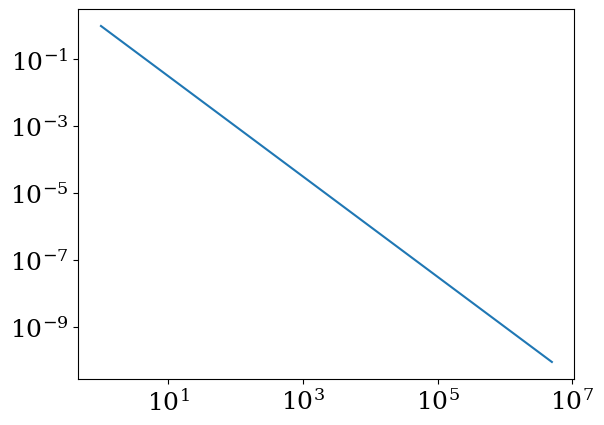

In [477]:
plt.loglog(np.arange(0, 5e6), calc_p_loop(np.arange(0, 5e6), a=1))

In [478]:
1/(1)**1.5

1.0

C:\Users\tmhab\AppData\Local\Temp\ipykernel_32792\2228480019.py:8: RuntimeWarning: divide by zero encountered in divide
  p_loop = a / np.abs(x) ** (1.5)


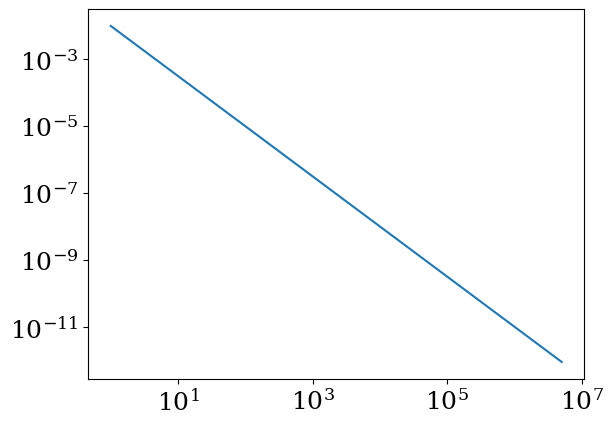

In [479]:
plt.loglog(np.arange(0, 5e6), calc_p_loop(np.arange(0, 5e6)))

In [520]:
%%time
# 2 marks competitive, no for loop

# mus = [-4.8,-4.8]
# mus = [-5,-5]
# mus = [-4,-5]
mus = [-2,-5]
# mus = [-0, -4.8]
# eps = -2
# j = -2

# sigma_1 = np.random.randint(1, size = n_nuc)
# sigma_1[20:40] = 2
# sigma_1[60:80] = 2

# sigma_2 = np.random.randint(1, size = n_nuc)
# sigma_2[40:60] = 2
# sigma_2[80:100] = 2

sigma_1 = marks_1#np.loadtxt("HNCFF683HCZ_H3K9me3_methyl.txt")
sigma_2 = marks_2#np.loadtxt("ENCFF919DOR_H3K27me3_methyl.txt")
sigmas = [sigma_1, sigma_2]

n_nuc = len(sigma_1)
n_iter = 100

amp = 0.05 # contact rpobability constant
# e_m = [2, 2]
# v_int = np.array([[-2,0],[0,-2]])

w_1 = np.zeros(n_nuc)
w_2 = np.zeros(n_nuc)
ws = [w_1, w_2]
ws_old = np.copy(ws)

s_arr = np.copy(ws)

f_bind_10 = eval_f_bind_competitive_arr_2([1,0], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
f_bind_01 = eval_f_bind_competitive_arr_2([0,1], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
f_bind_20 = eval_f_bind_competitive_arr_2([2,0], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
f_bind_02 = eval_f_bind_competitive_arr_2([0,2], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
f_bind_11 = eval_f_bind_competitive_arr_2([1,1], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
f_binds_comp = [f_bind_10, f_bind_01, f_bind_20, f_bind_02, f_bind_11]

print("convergence:")
for i in range(n_iter):
    # convergence test
    if (i != 0 and (i%10 == 0)) or (i==1) or (i==n_iter-1):
        ws_1_conv = np.sum(np.abs(ws[0] - ws_old[0]))
        ws_2_conv = np.sum(np.abs(ws[1] - ws_old[1]))
        # print(np.abs(np.sum(ws[0] - ws_old[0])))
        # print(np.abs(np.sum(ws[1] - ws_old[1])))
        print(ws_1_conv + ws_2_conv)
        
    ws_old = np.copy(ws)
    s_old = np.copy(s_arr)
    
    s_arr = calc_s_bind_comp(ws, mus, f_binds_comp) # calcultae binding state of HP1 and PRC1
    # s = calc_s_bind(w, sigma, eps, mu)

    # calculate array of looping probabilitys by nucleosome, with padding for convolution
    i = 0
    p_loop_ini = np.concatenate((calc_p_loop(np.arange(0,i)-i, amp),np.array([0]),calc_p_loop(np.arange(i + 1, n_nuc)-i, amp)))
    p_loop_reflect = np.concatenate((p_loop_ini[1:][::-1], p_loop_ini))

    # calculate part of interaction energy
    p_s_sum1 = signal.convolve(s_arr[0], p_loop_reflect, mode = "valid") # equivalent to [np.sum(p_loop * s_arr[0])] for i in range (n_nuc)
    p_s_sum2 = signal.convolve(s_arr[1], p_loop_reflect, mode = "valid") # equivalent to [np.sum(p_loop * s_arr[1])] for i in range (n_nuc)

    # calculate mean-field protein conjugate field via saddle point equation
    w_1_fast = v_int[0,0] * p_s_sum1 +  v_int[0,1] * p_s_sum2
    w_2_fast = v_int[1,1] * p_s_sum2 +  v_int[0,1] * p_s_sum1
    ws = [w_1_fast, w_2_fast]

convergence:
265383.50679640257
899.1721313038091
4.41374315695007
0.02673632610108832
0.0001755397601662779
1.209364233394918e-06
8.603049813716342e-09
1.4769391097494214e-10
8.820520962932177e-11
8.74207390505477e-11
8.577087477756873e-11
CPU times: total: 16.6 s
Wall time: 26.2 s


In [521]:
print(np.sum(np.abs(s_arr[0] - s_old[0]))) # change in binding at last iteration
print(np.sum(np.abs(s_arr[1] - s_old[1])))
print(len(s_arr[0]))

3.857772434834317e-11
1.6806673240610248e-13
451692


# Co-occupancy maps

### Coarse grain/ average binding states

In [524]:
# np.outer(s_arr[0], s_arr[1]) MEMORY ERROR

In [525]:
len(s_arr[0])

451692

In [526]:
# test = np.arange(1,13,1)

# np.mean(test.reshape(-1, 3), axis=1)

# np.mean(test[:(len(test)//5)*5].reshape(-1,5), axis=1) 

In [527]:
s_1, s_2 = s_arr

# factor = 36
# s_1_avgd = np.mean(s_1.reshape(-1, factor), axis=1)
# s_2_avgd = np.mean(s_2.reshape(-1, factor), axis=1)

factor = 500
s_1_avgd = np.mean(s_1[:(len(s_1)//factor)*factor].reshape(-1,factor), axis=1) 
s_2_avgd = np.mean(s_2[:(len(s_2)//factor)*factor].reshape(-1,factor), axis=1) 

# #select correct s_bind (mu matching looping binding theory)
s_bind_noloop = np.zeros(n_bind*9) # amount of each protein boun per nucleosome TYPE (each mark state)
for ib in range(n_bind*9):
    s_bind_noloop[ib] = s_bind_soln_arr_noloop[ib][np.where(mu1_array == mus[0]), np.where(mu2_array== mus[1])][0][0]
    
s_1_noloop = s_bind_noloop[pairs_ind] # number of protein 1 bound at each nucleosome
s_2_noloop = s_bind_noloop[pairs_ind+9] # number of protein 2 bound at each nucleosome

s_1_avgd_noloop = np.mean(s_1_noloop[:(len(s_1_noloop)//factor)*factor].reshape(-1,factor), axis=1) 
s_2_avgd_noloop = np.mean(s_2_noloop[:(len(s_2_noloop)//factor)*factor].reshape(-1,factor), axis=1) 

<Figure size 640x480 with 0 Axes>

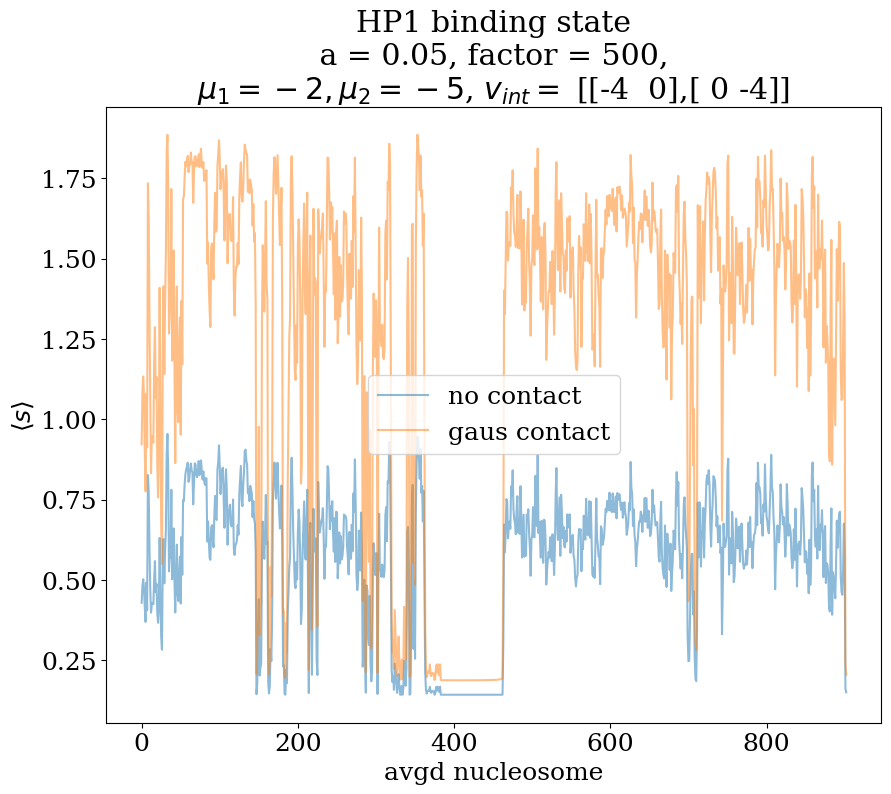

In [528]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(np.arange(n_nuc//factor), s_1_avgd_noloop, alpha = 0.5, label = "no contact")
plt.plot(np.arange(n_nuc//factor), s_1_avgd, alpha = 0.5, label = "gaus contact")
plt.title("HP1 binding state" + "\n" \
          + " a = %s, factor = %s, " % (amp, factor) + "\n" \
          "$\mu_1 = %s, \mu_2 = %s$," % (mus[0], mus[1])  \
          +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]" )
plt.xlabel("avgd nucleosome")
plt.ylabel(r"$ \langle s \rangle$")
plt.legend()

<Figure size 640x480 with 0 Axes>

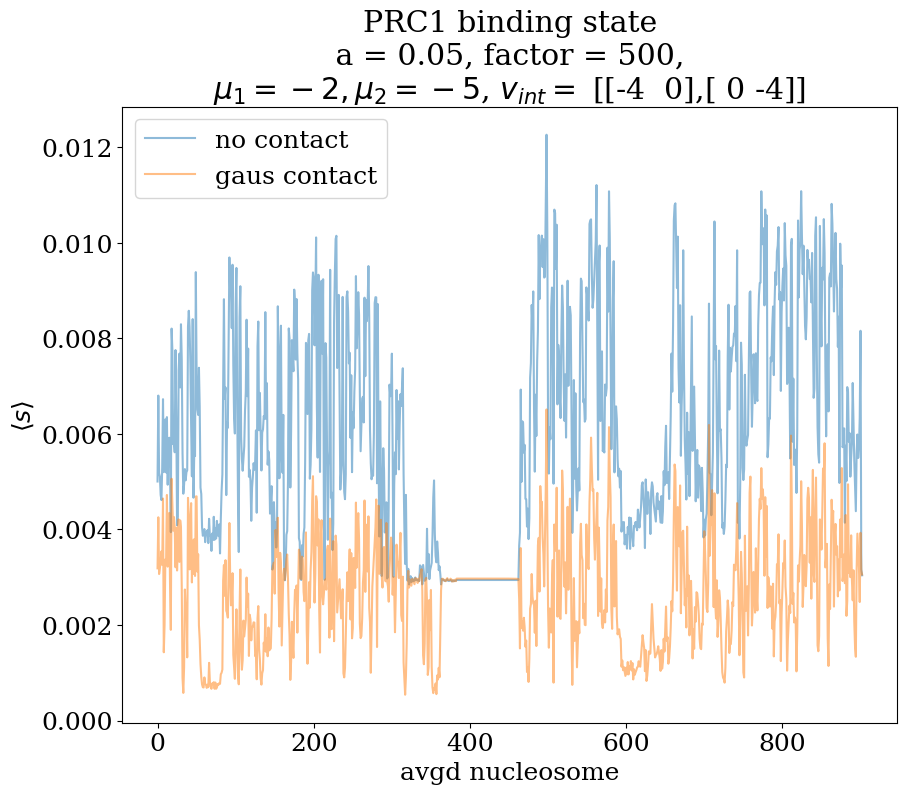

In [529]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(np.arange(n_nuc//factor), s_2_avgd_noloop, alpha = 0.5, label = "no contact")
plt.plot(np.arange(n_nuc//factor), s_2_avgd, alpha = 0.5, label = "gaus contact")
plt.title("PRC1 binding state" + "\n" \
          + " a = %s, factor = %s, " % (amp, factor) + "\n" \
          "$\mu_1 = %s, \mu_2 = %s$," % (mus[0], mus[1])  \
          +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]" )
plt.xlabel("avgd nucleosome")
plt.ylabel(r"$ \langle s \rangle$")
plt.legend()

In [530]:
n_nuc

451692

In [531]:
print(np.mean(s_1))
print(np.mean(s_2))

1.2618999864175091
0.0026945154847658973


<Figure size 640x480 with 0 Axes>

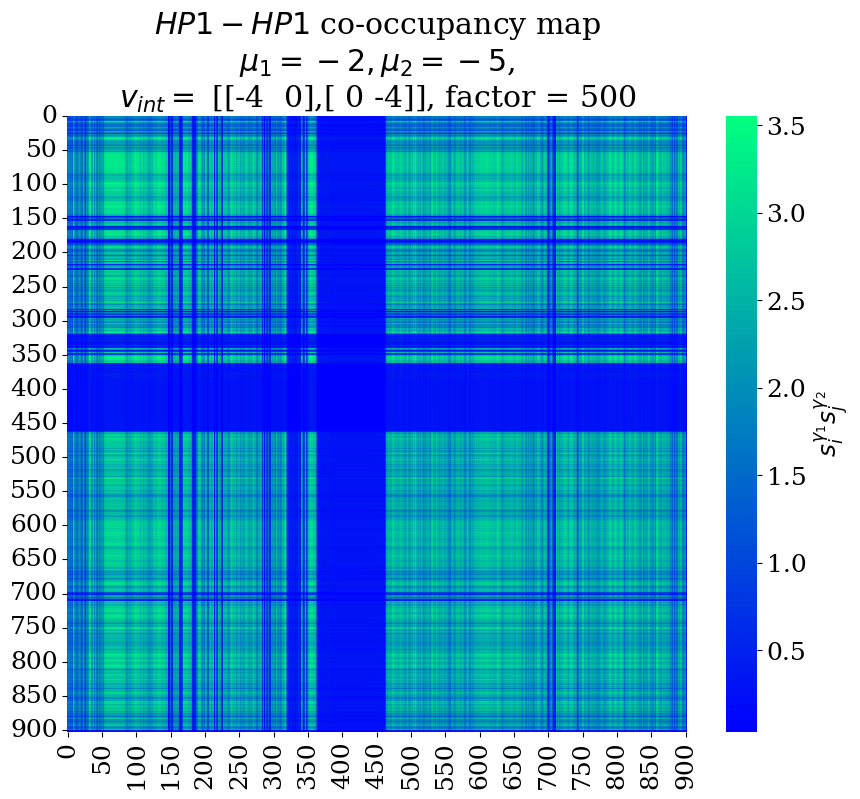

CPU times: total: 1.67 s
Wall time: 5.4 s


In [532]:
%%time

#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

co_occ_raw = np.outer(s_1_avgd, s_1_avgd)
co_occ_type = "$HP1-HP1$"

tick_arr = np.arange(0, n_nuc//factor)
# #protein 1
ax = sns.heatmap(co_occ_raw, linewidth=0., cmap = "winter", xticklabels=tick_arr, yticklabels=tick_arr, cbar_kws={'label':  r'$ s_i^{\gamma_1} s_j^{\gamma_2}$'})#, vmin=0, vmax=4)
# ax.set_xticks(ax.get_xticks()[::2])
# ax.set_xticklabels(mu2_array[::2].astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::2])
# ax.set_yticklabels(mu1_array[::2].astype(np.int64))

spacing = factor // 10
ax.set_xticks(ax.get_xticks()[::spacing])
ax.set_xticklabels(np.round(tick_arr[::spacing],0).astype(np.int64))
ax.set_yticks(ax.get_yticks()[::spacing])
ax.set_yticklabels(np.round(tick_arr[::spacing],0).astype(np.int64))

# ax.axhline(y=60, linewidth=4, color="white", linestyle = "--")
# ax.axhline(y=37, linewidth=4, color="white", linestyle = "--")

# plt.ylabel("$\mu^{(1)}$")
# plt.xlabel("$\mu^{(2)}$")
# plt.title(r"$ \langle f^{(1)} \rangle $" +  ", $e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
#           +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")
plt.title(co_occ_type + r" co-occupancy map" + "\n" \
          "$\mu_1 = %s, \mu_2 = %s$," % (mus[0], mus[1])  + "\n"\
          +  "$v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "], factor = %s" % factor )

plt.show()


<Figure size 640x480 with 0 Axes>

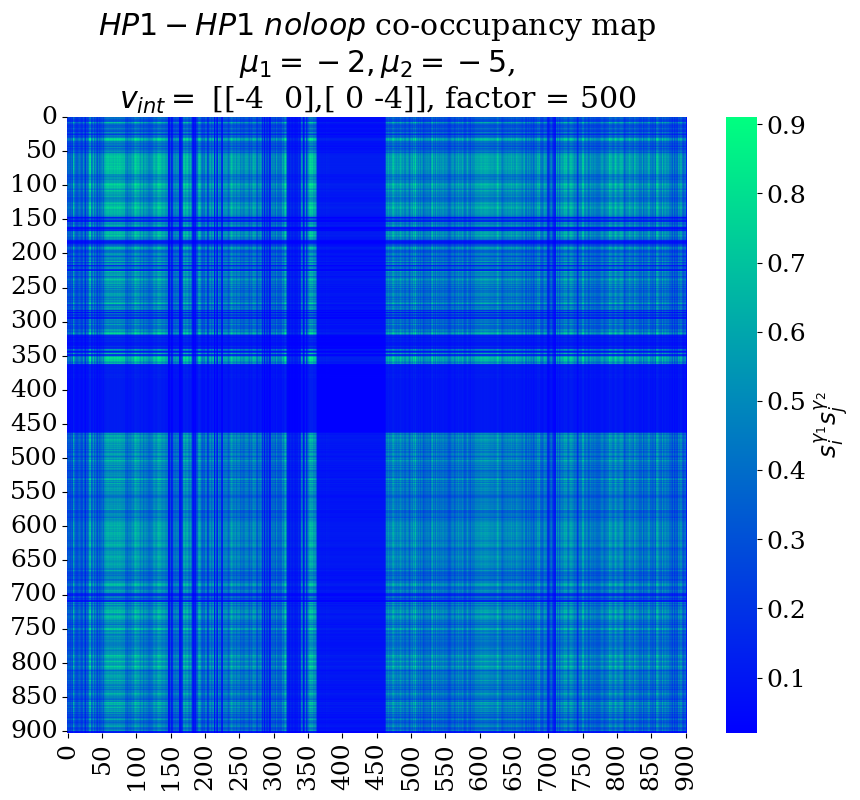

CPU times: total: 1.8 s
Wall time: 5.78 s


In [533]:
%%time

#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

co_occ_raw = np.outer(s_1_avgd_noloop, s_1_avgd_noloop)
co_occ_type = "$HP1-HP1 \ noloop$"

tick_arr = np.arange(0, n_nuc//factor)
# #protein 1
ax = sns.heatmap(co_occ_raw, linewidth=0., cmap = "winter", xticklabels=tick_arr, yticklabels=tick_arr, cbar_kws={'label':  r'$ s_i^{\gamma_1} s_j^{\gamma_2}$'})#, vmin=0, vmax=4)
# ax.set_xticks(ax.get_xticks()[::2])
# ax.set_xticklabels(mu2_array[::2].astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::2])
# ax.set_yticklabels(mu1_array[::2].astype(np.int64))

spacing = factor // 10
ax.set_xticks(ax.get_xticks()[::spacing])
ax.set_xticklabels(np.round(tick_arr[::spacing],0).astype(np.int64))
ax.set_yticks(ax.get_yticks()[::spacing])
ax.set_yticklabels(np.round(tick_arr[::spacing],0).astype(np.int64))

# ax.axhline(y=60, linewidth=4, color="white", linestyle = "--")
# ax.axhline(y=37, linewidth=4, color="white", linestyle = "--")

# plt.ylabel("$\mu^{(1)}$")
# plt.xlabel("$\mu^{(2)}$")
# plt.title(r"$ \langle f^{(1)} \rangle $" +  ", $e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
#           +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")
plt.title(co_occ_type + r" co-occupancy map" + "\n" \
          "$\mu_1 = %s, \mu_2 = %s$," % (mus[0], mus[1])  + "\n"\
          +  "$v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "], factor = %s" % factor )

plt.show()


<Figure size 640x480 with 0 Axes>

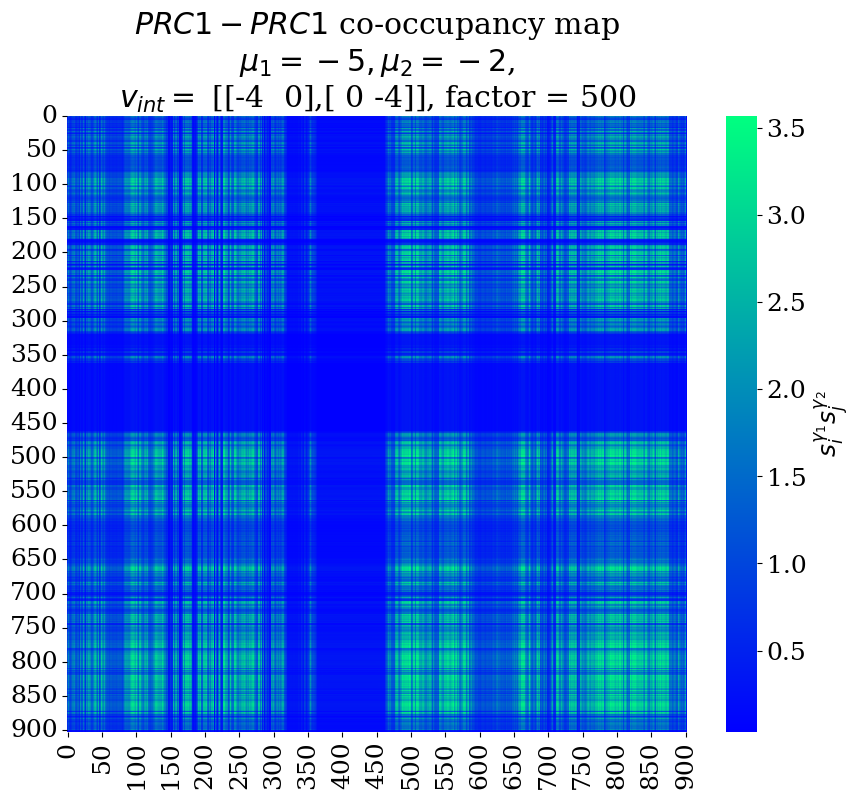

CPU times: total: 1.66 s
Wall time: 6.08 s


In [512]:
%%time

#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

co_occ_raw = np.outer(s_2_avgd, s_2_avgd)
co_occ_type = "$PRC1-PRC1$"

tick_arr = np.arange(0, n_nuc//factor)
# #protein 1
ax = sns.heatmap(co_occ_raw, linewidth=0., cmap = "winter", xticklabels=tick_arr, yticklabels=tick_arr, cbar_kws={'label':  r'$ s_i^{\gamma_1} s_j^{\gamma_2}$'})#, vmin=0, vmax=4)
# ax.set_xticks(ax.get_xticks()[::2])
# ax.set_xticklabels(mu2_array[::2].astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::2])
# ax.set_yticklabels(mu1_array[::2].astype(np.int64))

spacing = factor // 10
ax.set_xticks(ax.get_xticks()[::spacing])
ax.set_xticklabels(np.round(tick_arr[::spacing],0).astype(np.int64))
ax.set_yticks(ax.get_yticks()[::spacing])
ax.set_yticklabels(np.round(tick_arr[::spacing],0).astype(np.int64))

# ax.axhline(y=60, linewidth=4, color="white", linestyle = "--")
# ax.axhline(y=37, linewidth=4, color="white", linestyle = "--")

# plt.ylabel("$\mu^{(1)}$")
# plt.xlabel("$\mu^{(2)}$")
# plt.title(r"$ \langle f^{(1)} \rangle $" +  ", $e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
#           +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")
plt.title(co_occ_type + r" co-occupancy map" + "\n" \
          "$\mu_1 = %s, \mu_2 = %s$," % (mus[0], mus[1])  + "\n"\
          +  "$v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "], factor = %s" % factor )

plt.show()


<Figure size 640x480 with 0 Axes>

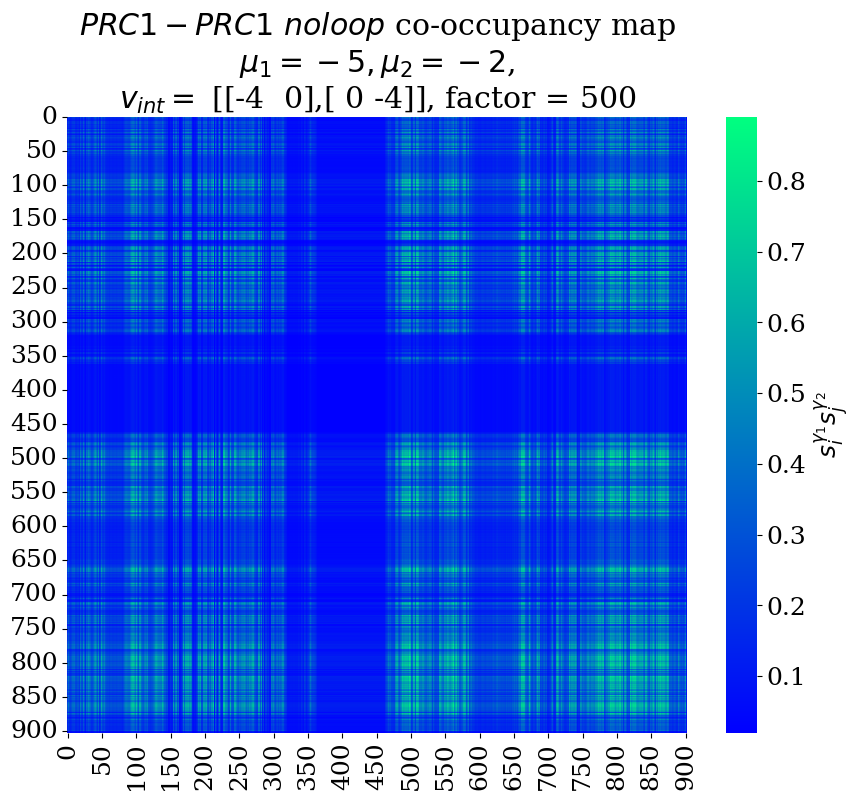

CPU times: total: 1.48 s
Wall time: 5.97 s


In [516]:
%%time

#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

co_occ_raw = np.outer(s_2_avgd_noloop, s_2_avgd_noloop)
co_occ_type = "$PRC1-PRC1 \ noloop$"

tick_arr = np.arange(0, n_nuc//factor)
# #protein 1
ax = sns.heatmap(co_occ_raw, linewidth=0., cmap = "winter", xticklabels=tick_arr, yticklabels=tick_arr, cbar_kws={'label':  r'$ s_i^{\gamma_1} s_j^{\gamma_2}$'})#, vmin=0, vmax=4)
# ax.set_xticks(ax.get_xticks()[::2])
# ax.set_xticklabels(mu2_array[::2].astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::2])
# ax.set_yticklabels(mu1_array[::2].astype(np.int64))

spacing = factor // 10
ax.set_xticks(ax.get_xticks()[::spacing])
ax.set_xticklabels(np.round(tick_arr[::spacing],0).astype(np.int64))
ax.set_yticks(ax.get_yticks()[::spacing])
ax.set_yticklabels(np.round(tick_arr[::spacing],0).astype(np.int64))

# ax.axhline(y=60, linewidth=4, color="white", linestyle = "--")
# ax.axhline(y=37, linewidth=4, color="white", linestyle = "--")

# plt.ylabel("$\mu^{(1)}$")
# plt.xlabel("$\mu^{(2)}$")
# plt.title(r"$ \langle f^{(1)} \rangle $" +  ", $e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
#           +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")
plt.title(co_occ_type + r" co-occupancy map" + "\n" \
          "$\mu_1 = %s, \mu_2 = %s$," % (mus[0], mus[1])  + "\n"\
          +  "$v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "], factor = %s" % factor )

plt.show()


<Figure size 640x480 with 0 Axes>

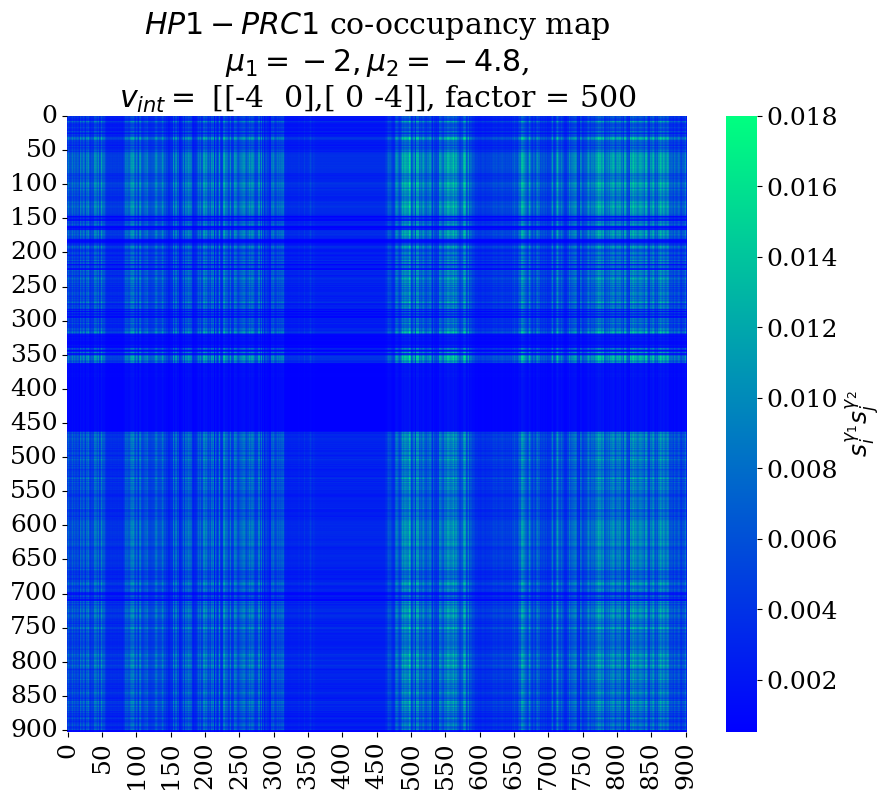

CPU times: total: 4.31 s
Wall time: 6.64 s


In [309]:
%%time

#density maps
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

co_occ_raw = np.outer(s_1_avgd, s_2_avgd)
co_occ_type = "$HP1-PRC1$"

tick_arr = np.arange(0, n_nuc//factor)
# #protein 1
ax = sns.heatmap(co_occ_raw, linewidth=0., cmap = "winter", xticklabels=tick_arr, yticklabels=tick_arr, cbar_kws={'label':  r'$ s_i^{\gamma_1} s_j^{\gamma_2}$'}, vmin=0, vmax=4)
# ax.set_xticks(ax.get_xticks()[::2])
# ax.set_xticklabels(mu2_array[::2].astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::2])
# ax.set_yticklabels(mu1_array[::2].astype(np.int64))

spacing = factor // 10
ax.set_xticks(ax.get_xticks()[::spacing])
ax.set_xticklabels(np.round(tick_arr[::spacing],0).astype(np.int64))
ax.set_yticks(ax.get_yticks()[::spacing])
ax.set_yticklabels(np.round(tick_arr[::spacing],0).astype(np.int64))

# ax.axhline(y=60, linewidth=4, color="white", linestyle = "--")
# ax.axhline(y=37, linewidth=4, color="white", linestyle = "--")

# plt.ylabel("$\mu^{(1)}$")
# plt.xlabel("$\mu^{(2)}$")
# plt.title(r"$ \langle f^{(1)} \rangle $" +  ", $e_B^{(1)} = $" + \
#           str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) \
#           +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]")
plt.title(co_occ_type + r" co-occupancy map" + "\n" \
          "$\mu_1 = %s, \mu_2 = %s$," % (mus[0], mus[1])  + "\n"\
          +  "$v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "], factor = %s" % factor )

plt.show()


In [310]:
# TODO
# compare to andy result DONE
# OPTIMIZE- change form of looping probabililty to only consider 200 nearest? DONE
# confrim convergence of ws DONE

# Co-occupancy map. 
        # compress results- average binding of every n beads DONE
        # determine threshold/ different phases (different phase behvior at low mu both, mow mu one, low mu other)
        # compare to chromo? understand phase behavior?

        #COMPARE co-occupancy from binding withouot looping (old theory) to these maps. 
# generate 2d (average) density maps vs mu? to compare with theory

# look at different v_int systems - understand relationship between mu, v_int, and a (looping prob magnitude)


# Andys work

In [ ]:
# # single nucleosome binding partition function
# def calc_q_bind(w, sigma, eps = 0, mu = 0):
#     q_bind = 1. + np.exp(-eps * sigma + mu - w)
    
#     return q_bind
# # average s_bind
# # sigma: mark state!
# # QUESTION what is epsilon (binding param?)
# def calc_s_bind(w, sigma, eps = 0, mu = 0):
#     q_bind = 1. + np.exp(-eps * sigma + mu - w)
#     s_bind = np.exp(-eps * sigma + mu - w) / q_bind
    
#     return s_bind

# # x: genomic distance
# def calc_p_loop(x, a = 1):
    
#     p_loop = a / np.abs(x) ** (1.5)
    
#     return p_loop

# n_nuc = 100
# n_iter = 70

# w = np.zeros(n_nuc)

# mu = -4.8
# eps = -2
# sigma = np.random.randint(1, size = n_nuc)
# sigma[20:40] = 1
# sigma[60:80] = 1
# j = -2

# for i in range(n_iter):
#     s = calc_s_bind(w, sigma, eps, mu)
#     for i in range(n_nuc):
#         p_loop = np.concatenate((calc_p_loop(np.arange(0,i)-i),np.array([0]),calc_p_loop(np.arange(i + 1, n_nuc)-i))) 
#         # gives array of looping probs centered at ith nucleosome (at which probability = 0) 
#         w[i] = j * np.sum(p_loop * s)
#         # QUESTION: why is this the expression for w? saddle point equation?

# # ANDY with convergence test
# n_nuc = 100
# n_iter = 70

# w = np.zeros(n_nuc)
# w_old = np.zeros(n_nuc)

# mu = -4.8
# eps = -2
# sigma = np.random.randint(1, size = n_nuc)
# sigma[20:40] = 1
# sigma[60:80] = 1
# j = -2

# for i in range(n_iter):
#     print("convergence test:")
#     # print("w: ", w[0:10])
#     # print("w_old: ", w_old[0:10])    
#     print(np.sum(w-w_old))
#     s = calc_s_bind(w, sigma, eps, mu)
#     w_old = np.copy(w)
#     for i in range(n_nuc):
#         p_loop = np.concatenate((calc_p_loop(np.arange(0,i)-i),np.array([0]),calc_p_loop(np.arange(i + 1, n_nuc)-i))) 
#         # gives array of looping probs centered at ith nucleosome (at which probability = 0) 
#         w[i] = j * np.sum(p_loop * s)
#         # QUESTION: why is this the expression for w? saddle point equation?


# sigma

# # QUESTION: why is final s_bind ("s") this way? middle unmarked section has binding
# plt.figure()
# font = {'family' : 'serif',
#         'weight':'normal',
#         'size': 18}
# plt.rc('font', **font)

# plt.plot(s, 'ko-')
# plt.plot(sigma, 'bo-')

# plt.show()


# n_nuc = 10000
# n_iter = 20

# w = np.zeros(n_nuc)

# mu = -4.5
# eps = -2
# sigma = np.random.randint(2, size = n_nuc)
# sigma[40:60] = 1
# j = -2

# for i in range(n_iter):
#     s = calc_s_bind(w, sigma, eps, mu)
#     for i in range(n_nuc):
#         p_loop = np.concatenate((calc_p_loop(np.arange(0,i)-i),np.array([0]),calc_p_loop(np.arange(i + 1, n_nuc)-i)))
#         w[i] = j * np.sum(p_loop * s)

# plt.figure()
# font = {'family' : 'serif',
#         'weight':'normal',
#         'size': 18}
# plt.rc('font', **font)

# plt.plot(s, 'ko-')
# plt.plot(sigma, 'bo-')

# plt.show()


# Old efficiency testing code

In [ ]:


# # TESTING for efficiency


# # 2 marks competitive

# n_nuc = 4
# n_iter = 1

# w_1 = np.zeros(n_nuc)
# w_2 = np.zeros(n_nuc)
# ws = [w_1, w_2]

# # mus = [-4.8,-4.8]
# mus = [-4.8,-10]
# # eps = -2
# # j = -2

# sigma_1 = [0,2,1,2]#np.random.randint(1, size = n_nuc)
# # sigma_1[2:4] = 2
# # sigma_1[60:80] = 2

# sigma_2 = np.random.randint(1, size = n_nuc)
# # sigma_2[40:60] = 2
# # sigma_2[80:100] = 2

# sigmas = [sigma_1, sigma_2]

# # e_m = [1.52, 1.52]
# # v_int = np.array([[-4,0],[0,-4]])

# e_m = [2, 2]
# v_int = np.array([[-2,0],[0,-2]])

# f_bind_10 = eval_f_bind_competitive_arr_2([1,0], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
# f_bind_01 = eval_f_bind_competitive_arr_2([0,1], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
# f_bind_20 = eval_f_bind_competitive_arr_2([2,0], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
# f_bind_02 = eval_f_bind_competitive_arr_2([0,2], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
# f_bind_11 = eval_f_bind_competitive_arr_2([1,1], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
# f_binds_comp = [f_bind_10, f_bind_01, f_bind_20, f_bind_02, f_bind_11]

# p_loop_initial = None

# for i in range(n_iter):
#     s_arr = calc_s_bind_comp(ws, mus, f_binds_comp) # binding state of HP1 and PRC1
#     # s = calc_s_bind(w, sigma, eps, mu)
    
#     n_nuc = 4
#     for i in range(n_nuc):
#         p_loop = np.concatenate((calc_p_loop(np.arange(0,i)-i),np.array([0]),calc_p_loop(np.arange(i + 1, n_nuc)-i)))
#         if i == 0:
#             p_loop_initial = p_loop
#         print("-------------------------")
#         print("p_loop:", p_loop)
#         print("s_bind:", s_arr[0])
#         print("sum(s_bind*p_loop):", np.sum(s_arr[0]*p_loop))
#         print("conv:", signal.convolve(s_arr[0], p_loop, mode = "valid"))
#         w_1[i] = v_int[0,0] * np.sum(p_loop * s_arr[0]) +  v_int[0,1] * np.sum(p_loop * s_arr[1])
#         w_2[i] = v_int[1,1] * np.sum(p_loop * s_arr[1]) +  v_int[0,1] * np.sum(p_loop * s_arr[0])
#         w_s = [w_1, w_2]

#         p_loop_reflect = np.concatenate((p_loop_initial[1:][::-1], p_loop_initial))
#         print("conv reflect:", signal.convolve(s_arr[0], p_loop_reflect, mode = "valid"))        
#         # print("sum(s_bind*p_loop):", np.sum(s_arr[0]*p_loop))
# print("w1:", w_1)
# print("w2:", w_2)

# i = 0
# p_loop_ini = np.concatenate((calc_p_loop(np.arange(0,i)-i),np.array([0]),calc_p_loop(np.arange(i + 1, n_nuc)-i)))
# p_loop_reflect = np.concatenate((p_loop_ini[1:][::-1], p_loop_ini))

# p_s_sum1 = signal.convolve(s_arr[0], p_loop_reflect, mode = "valid") # equivalent to [np.sum(p_loop * s_arr[0])] for i in range (n_nuc)
# p_s_sum2 = signal.convolve(s_arr[1], p_loop_reflect, mode = "valid") # equivalent to [np.sum(p_loop * s_arr[1])] for i in range (n_nuc)
# w_1_fast = v_int[0,0] * p_s_sum1 +  v_int[0,1] * p_s_sum2
# w_2_fast = v_int[1,1] * p_s_sum2 +  v_int[0,1] * p_s_sum1

# print("new w1:", w_1_fast)
# print("new w2:", w_2_fast)
